# Defining custom operations

This notebook describes the tlm_adjoint 'escape hatch' mechanism, which allows custom operations to be defined, recorded by the internal manager, and used in higher order derivative calculations.

The approach used by tlm_adjoint to define custom operations is described in

- James R. Maddison, Daniel N. Goldberg, and Benjamin D. Goddard, 'Automated calculation of higher order partial differential equation constrained derivative information', SIAM Journal on Scientific Computing, 41(5), pp. C417&ndash;C445, 2019, doi: 10.1137/18M1209465

We assume real spaces and a real build of Firedrake throughout.

## Forward problem

We consider the Poisson equation in the unit square domain

$$\nabla^2 u = m \quad \text{on} ~ \Omega = \left( 0, 1 \right)^2,$$

with

$$\int_\Omega m = 0,$$

subject to boundary conditions

$$\nabla u \cdot \hat{n} = 0,$$

where $\hat{n}$ is an outward unit normal on the boundary $\partial \Omega$ of the domain $\Omega$.

We consider a continuous Galerkin discretization, now seeking $u \in V$ such that

$$\forall \zeta \in V \qquad \int_\Omega \nabla \zeta \cdot \nabla u = -\int_\Omega \zeta m,$$

where $V$ is a real $P_1$ continuous finite element space defining functions on the domain $\Omega = \left( 0, 1 \right)^2$. $m \in V$ is now defined via

$$m = \mathcal{I} \left[ \cos \left( \pi x \right) \cos \left( \pi y \right) \right] - k,$$

where $\mathcal{I}$ maps to an element of $V$ through interpolation at mesh vertices, and where $k$ is defined so that $\int_\Omega m = 0$.

As stated the discrete problem does not have a unique solution &ndash; given any solution $u_0$ to the problem we can define a new solution $u_1 = u_0 + c_1$ for any scalar $c_1$. We need to identify a solution by supplying an appropriate constraint. We will use the constraint

$$\sum_i \tilde{u}_i = 0,$$

where the $\tilde{u}_i$ are the degrees of freedom associated with $u \in V$.

An implementation using Firedrake, solving for $u$ and then computing $\frac{1}{2} \int_\Omega u^2$, takes the form

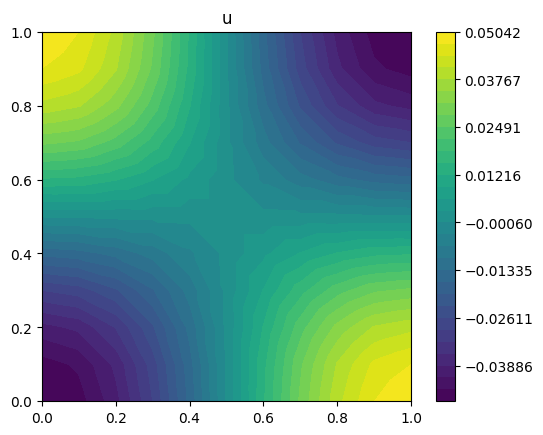

In [1]:
%matplotlib inline

from firedrake import *
from firedrake.pyplot import tricontourf

import matplotlib.pyplot as plt
import numpy as np

mesh = UnitSquareMesh(10, 10)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test, trial = TestFunction(space), TrialFunction(space)


def forward(m):
    k = Constant(assemble(m * dx) / assemble(Constant(1.0) * dx(mesh)))
    m_tilde = Function(m.function_space(), name="m_tilde").interpolate(m - k)
    
    u = Function(space, name="u")
    nullspace = VectorSpaceBasis(comm=u.comm, constant=True)

    solve(inner(grad(trial), grad(test)) * dx == -inner(m_tilde, test) * dx,
          u, nullspace=nullspace, transpose_nullspace=nullspace,
          solver_parameters={"ksp_type": "cg", "pc_type": "hypre",
                             "pc_hypre_type": "boomeramg",
                             "ksp_rtol": 1.0e-10, "ksp_atol": 1.0e-16})

    J = assemble(0.5 * inner(u, u) * dx)
    return u, J


m = Function(space, name="m").interpolate(cos(pi * X[0]) * cos(pi * X[1]))

u, J = forward(m)


def plot_output(u, title):
    r = (u.dat.data_ro.min(), u.dat.data_ro.max())
    eps = (r[1] - r[0]) * 1.0e-12
    p = tricontourf(u, np.linspace(r[0] - eps, r[1] + eps, 32))
    plt.gca().set_title(title)
    plt.colorbar(p)
    plt.gca().set_aspect(1.0)


plot_output(u, title="u")

## Adding tlm_adjoint

Next we add the use of tlm_adjoint, which requires some minor modification of the forward code.

`compute_gradient` is used to compute the derivative of $\frac{1}{2} \int_\Omega u^2$ with respect to $m$, subject to the contraint that the forward problem is solved. The derivative is visualized using a Riesz map defined by the $L^2$ inner product. A Taylor remainder convergence test is used to verify the derivative.

Note that, given an arbitrary $m \in V$, we define

$$\tilde{m} = m - \frac{\int_\Omega m}{\int_\Omega 1},$$

so that $\int_\Omega \tilde{m} = 0$, and use $\tilde{m}$ in place of $m$ when solving the discrete Poisson problem.

Error norms, no adjoint   = [6.16667546e-08 3.06309860e-08 1.52648952e-08 7.61979814e-09
 3.80673670e-09]


Orders,      no adjoint   = [1.00950111 1.00477412 1.002393   1.00119799]


Error norms, with adjoint = [8.09565062e-10 2.02391252e-10 5.05978057e-11 1.26494478e-11
 3.16236024e-12]


Orders,      with adjoint = [2.0000001  2.00000021 2.00000041 2.00000078]


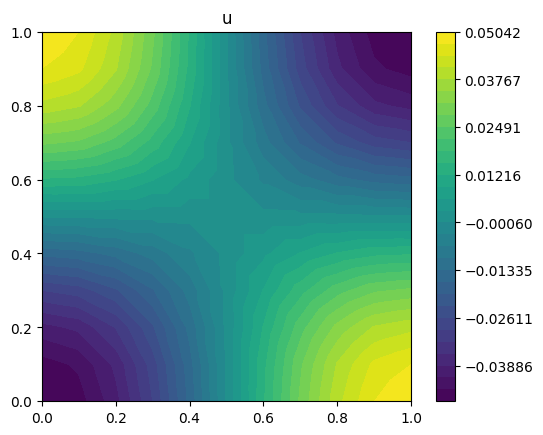

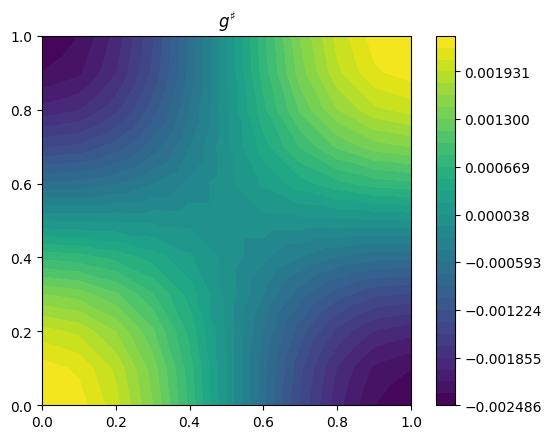

In [2]:
%matplotlib inline

from firedrake import *
from tlm_adjoint.firedrake import *
from firedrake.pyplot import tricontourf

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(54151610)
reset_manager()

mesh = UnitSquareMesh(10, 10)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test, trial = TestFunction(space), TrialFunction(space)


def forward(m):
    v = Constant(name="v")
    Assembly(v, Constant(1.0) * dx(mesh)).solve()
    k = Constant(name="k")
    Assembly(k, (m / v) * dx).solve()
    m_tilde = Function(m.function_space(), name="m_tilde").interpolate(m - k)
    
    u = Function(space, name="u")
    nullspace = VectorSpaceBasis(comm=u.comm, constant=True)

    solve(inner(grad(trial), grad(test)) * dx == -inner(m_tilde, test) * dx,
          u, nullspace=nullspace, transpose_nullspace=nullspace,
          solver_parameters={"ksp_type": "cg", "pc_type": "hypre",
                             "pc_hypre_type": "boomeramg",
                             "ksp_rtol": 1.0e-10, "ksp_atol": 1.0e-16})

    J = Functional(name="J")
    J.assign(0.5 * inner(u, u) * dx)
    return u, J


m = Function(space, name="m").interpolate(cos(pi * X[0]) * cos(pi * X[1]))

start_manager()
u, J = forward(m)
stop_manager()

dJ = compute_gradient(J, m)


def plot_output(u, title):
    r = (u.dat.data_ro.min(), u.dat.data_ro.max())
    eps = (r[1] - r[0]) * 1.0e-12
    p = tricontourf(u, np.linspace(r[0] - eps, r[1] + eps, 32))
    plt.gca().set_title(title)
    plt.colorbar(p)
    plt.gca().set_aspect(1.0)


plot_output(u, title="u")
plot_output(dJ.riesz_representation("L2"), title=r"$g^\sharp$")


def forward_J(m):
    _, J = forward(m)
    return J


min_order = taylor_test(forward_J, m, J_val=J.value, dJ=dJ)
assert min_order > 1.99

## Defining a custom `Equation`

Since the $u$ we have computed should satisfy

$$\sum_i \tilde{u}_i = 0,$$

we should have that the derivative of this quantity with respect to $m$, subject to the forward problem being solved, is zero. We will compute this derivative by defining a custom operation which sums the degrees of freedom of a finite element discretized function. We can do this by inheriting from the `Equation` class and implementing appropriate methods.

In [3]:
from tlm_adjoint import Equation


class Sum(Equation):
    def __init__(self, x, y):
        super().__init__(x, deps=(x, y), nl_deps=(), ic=False, adj_ic=False,
                         adj_type="conjugate_dual")

    def forward_solve(self, x, deps=None):
        if deps is None:
            deps = self.dependencies()
        _, y = deps
        with y.dat.vec_ro as y_v:
            y_sum = y_v.sum()
        x.assign(y_sum)

    def adjoint_jacobian_solve(self, adj_x, nl_deps, b):
       return b

    def adjoint_derivative_action(self, nl_deps, dep_index, adj_x):
        if dep_index != 1:
            raise ValueError("Unexpected dep_index")

        _, y = self.dependencies()
        b = Cofunction(var_space(y).dual())
        adj_x = float(adj_x)
        b.dat.data[:] = -adj_x
        return b

    def tangent_linear(self, tlm_map):
        tau_x, tau_y = (tlm_map[dep] for dep in self.dependencies())
        if tau_y is None:
            return ZeroAssignment(tau_x)
        else:
            return Sum(tau_x, tau_y)

We'll investgate how this is put together shortly.

First, we check that the `Sum` class works. In the following we check that we can compute the sum of the degrees of freedom of a function, and then use Taylor remainder convergence tests to verify a first order tangent-linear calculation, a first order adjoint calculation, and a reverse-over-forward adjoint calculation of a Hessian action.

In [4]:
from firedrake import *
from tlm_adjoint.firedrake import *

import numpy as np

np.random.seed(13561700)
reset_manager()


def forward(m):
    m_sum = Float(name="m_sum")
    Sum(m_sum, m).solve()

    J = m_sum ** 3
    
    return m_sum, J


def forward_J(m):
    _, J = forward(m)
    return J


mesh = UnitIntervalMesh(10)
x, = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Discontinuous Lagrange", 0)

m = Function(space, name="m")
m.interpolate(exp(-x) * sin(pi * x))
with m.dat.vec_ro as m_v:
    m_sum_ref = m_v.sum()

start_manager()
m_sum, J = forward(m)
stop_manager()

# Verify the forward calculation

print(f"{float(m_sum)=}")
print(f"{m_sum_ref=}")
assert abs(float(m_sum) - m_sum_ref) == 0.0

# Verify tangent-linear and adjoint calculations

min_order = taylor_test_tlm(forward_J, m, tlm_order=1)
assert min_order > 1.99

min_order = taylor_test_tlm_adjoint(forward_J, m, adjoint_order=1)
assert min_order > 1.99

min_order = taylor_test_tlm_adjoint(forward_J, m, adjoint_order=2)
assert min_order > 1.99

float(m_sum)=3.97146153200585
m_sum_ref=3.97146153200585
Error norms, no tangent-linear   = [1.4597981  0.72709661 0.36284904 0.18124987 0.09058129]


Orders,      no tangent-linear   = [1.00554988 1.00277762 1.00138948 1.00069491]


Error norms, with tangent-linear = [1.11954288e-02 2.79527053e-03 6.98369299e-04 1.74536283e-04
 4.36270656e-05]


Orders,      with tangent-linear = [2.00184997 2.00092587 2.00046316 2.00023164]


Error norms, no adjoint   = [1.68516173 0.83885294 0.41849655 0.20901605 0.10445   ]


Orders,      no adjoint   = [1.00639725 1.00320219 1.00160198 1.00080121]


Error norms, with adjoint = [1.48897315e-02 3.71693487e-03 9.28546465e-04 2.32050710e-04
 5.80019391e-05]


Orders,      with adjoint = [2.00213243 2.0010674  2.00053399 2.00026707]


Error norms, no adjoint   = [3.70748562 1.85093251 0.92476368 0.46220619 0.23105919]


Orders,      no adjoint   = [1.00218881 1.00109565 1.00054814 1.00027415]


Error norms, with adjoint = [1.12412164e-02 2.81030409e-03 7.02576023e-04 1.75644006e-04
 4.39110014e-05]


Orders,      with adjoint = [2. 2. 2. 2.]


We can now use `Sum` with the Poisson solver. We find, as expected, that the derivative of the sum of the degrees of freedom for $u$ with respect to $m$, subject to the forward problem being solved, is zero.

In [5]:
%matplotlib inline

from firedrake import *
from tlm_adjoint.firedrake import *

import matplotlib.pyplot as plt
import numpy as np

reset_manager()

mesh = UnitSquareMesh(10, 10)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test, trial = TestFunction(space), TrialFunction(space)


def forward(m):
    v = Constant(name="v")
    Assembly(v, Constant(1.0) * dx(mesh)).solve()
    k = Constant(name="k")
    Assembly(k, (m / v) * dx).solve()
    m_tilde = Function(m.function_space(), name="m_tilde").interpolate(m - k)
    
    u = Function(space, name="u")
    nullspace = VectorSpaceBasis(comm=u.comm, constant=True)

    solve(inner(grad(trial), grad(test)) * dx == -inner(m_tilde, test) * dx,
          u, nullspace=nullspace, transpose_nullspace=nullspace,
          solver_parameters={"ksp_type": "cg", "pc_type": "hypre",
                             "pc_hypre_type": "boomeramg",
                             "ksp_rtol": 1.0e-10, "ksp_atol": 1.0e-16})

    J = Functional(name="J")
    J.assign(0.5 * inner(u, u) * dx)
    
    u_sum = Constant(name="u_sum")
    Sum(u_sum, u).solve()

    K = Functional(name="K")
    K.assign(u_sum)

    return u, J, K


m = Function(space, name="m").interpolate(cos(pi * X[0]) * cos(pi * X[1]))

start_manager()
u, J, K = forward(m)
stop_manager()

dJ, dK = compute_gradient((J, K), m)

dK_norm = abs(dK.dat.data_ro).max()
print(f"{dK_norm=}")

assert dK_norm == 0.0

dK_norm=np.float64(0.0)


## `Equation` methods

We now return to the definition of the `Sum` class, and consider each method in turn.

### `__init__`

```
def __init__(self, x, y):
    super().__init__(x, deps=(x, y), nl_deps=(), ic=False, adj_ic=False,
                     adj_type="conjugate_dual")
```

The arguments passed to the base class constructor are:

- The output of the forward operation, `x`.
- `deps`: Defines all inputs and outputs of the forward operation.
- `nl_deps`: Defines elements of `deps` on which the associated adjoint calculations can depend.
- `ic`: Whether the forward operation accepts a non-zero 'initial guess'.
- `adj_ic`: Whether an adjoint solve accepts a non-zero 'initial guess'.
- `adj_type`: Either `"primal"` or `"conjugate_dual"` defining the space for an associated adjoint variable.

For this operation there is one output `x` and one input `y`. The operation is defined by the forward residual function

$$F \left( x, y \right) = x - \sum_i \tilde{u}_i.$$

Given a value for $y$ the output of the operation is defined to be the $x$ for which $F \left( x, y \right) = 0$. $F$ depends linearly on both $x$ and $y$, and so associated adjoint calculations are independent of both $x$ and $y$. Hence we set `deps=(x, y)` and `nl_deps=()`.

`ic` and `adj_ic` are used to indicate whether non-zero initial guesses should be supplied to forward and adjoint iterative solvers respectively. Here we do not use iterative solvers, and so no non-zero initial guesses are needed. Hence we set `ic=False` and `adj_ic=False`.

`adj_type` indicates whether an adjoint variable associated with the operation is:

- In the same space as `x`. This is the case where $F$ maps to an element in the antidual space associated with $x$, and is indicated with `adj_x_type="primal"`. A typical example of this case is an operation defined via the solution of a finite element variational problem.
- In the antidual space associated with the space for `x`. This is the case where $F$ maps to an element in same space as $x$, and is indiciated with `adj_x_type="conjugate_dual"`.

### `forward_solve`

```
def forward_solve(self, x, deps=None):
    if deps is None:
        deps = self.dependencies()
    _, y = deps
    with y.dat.vec_ro as y_v:
        y_sum = y_v.sum()
    x.assign(y_sum)
```

This method computes the output of the forward operation, storing the result in `x`. `deps` is used in rerunning the forward calculation when making use of a checkpointing schedule. If supplied, `deps` contains values associated with the dependencies as defined in the constructor (defined by the `deps` argument passed to the base class constructor). Otherwise the values contained in `self.dependencies()` are used.

### `adjoint_jacobian_solve`

```
def adjoint_jacobian_solve(self, adj_x, nl_deps, b):
   return b
```

Solves a linear problem

$$\frac{\partial F}{\partial x}^T \lambda = b,$$

for the adjoint solution $\lambda$, returning the result. The right-hand-side $b$ is defined by the argument `b`. In this example $\partial F / \partial x$ is simply the identity, and so $\lambda = b$.

`adj_x` can contain an initial guess for an iterative solver used to compute $\lambda$. `nl_deps` contains values associated with the forward dependencies of the adjoint, as defined in the constructor (defined by the `nl_deps` argument passed to the base class constructor).

### `adjoint_derivative_action`

```
def adjoint_derivative_action(self, nl_deps, dep_index, adj_x):
    if dep_index != 1:
        raise ValueError("Unexpected dep_index")

    _, y = self.dependencies()
    b = Cofunction(var_space(y).dual())
    adj_x = float(adj_x)
    b.dat.data[:] = -adj_x
    return b
```

Computes

$$\frac{\partial F}{\partial v}^T \lambda,$$

where $v$ is the `dep_index`th dependency (for the dependencies defined by the `deps` argument passed to the base class constructor). Again `nl_deps` contains values associated with the forward dependencies of the adjoint, as defined in the constructor.

### `tangent_linear`

```
def tangent_linear(self, tlm_map):
    tau_x, tau_y = (tlm_map[dep] for dep in self.dependencies())
    if tau_y is None:
        return ZeroAssignment(tau_x)
    else:
        return Sum(tau_x, tau_y)
```

Constructs a tangent-linear operation, for a tangent-linear computing directional derivatives with respect to the control defined by `M` with direction defined by `dM`. `tlm_map` is used to access tangent-linear variables.

The new operation is defined by the residual function

$$F_\tau \left( \tau_x, \tau_y \right) = \frac{\partial F}{\partial x} \tau_x + \frac{\partial F}{\partial y} \tau_y,$$

where $\tau_x$ and $\tau_y$ are the tangent-linear variables associated with $x$ and $y$ respectively. Given a value for $\tau_y$ the output of the operation is defined to be the $\tau_x$ for which $F_\tau \left( \tau_x, \tau_y \right) = 0$.

Note that this method returns an `Equation` instance &ndash; here either a `ZeroAssignment`, for the case where the tangent-linear operation sets a tangent-linear variable equal to zero, or another `Sum`. This new operation can then be recorded by the internal manager, so that reverse-over-forward algorithmic differentiation can be applied.

### Reference dropping

An important method, not defined in this example, is the `drop_references` method. This method is used to drop references to forward data. For example if an `Equation` subclass defines a `Function` attribute `_function`, then the `drop_references` method might look like

```
def drop_references(self):
    super().drop_references()
    self._function = var_replacement(self._function)
```

Here `var_replacement` returns a 'symbolic only' version of `self._function`, which can for example be used in UFL expressions, but which has no associated value.

## Defining custom operations using JAX

In some cases it may be more convenient to directly implement an operation using lower level code. tlm_adjoint integrates with [JAX](https://jax.readthedocs.io) to allow this. For example a Firedrake `Function` can be converted to a JAX array using

```
v = to_jax(x)
```

and the result converted back to a Firedrake `Function` using

```
x = to_firedrake(v, space)
```

Here we use JAX to compute the sum of the degrees of freedom for a Firedrake function (assuming a serial calculation).

In [6]:
from firedrake import *
from tlm_adjoint.firedrake import *

import numpy as np
import jax

np.random.seed(81976463)
jax.config.update("jax_enable_x64", True)
reset_manager()


def forward(m):
    m_sum = new_jax_float(name="m_sum")
    call_jax(m_sum, to_jax(m), lambda v: v.sum())

    J = m_sum ** 3
    
    return m_sum, J


def forward_J(m):
    _, J = forward(m)
    return J


mesh = UnitIntervalMesh(10)
x, = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Discontinuous Lagrange", 0)

m = Function(space, name="m")
m.interpolate(exp(-x) * sin(pi * x))
with m.dat.vec_ro as m_v:
    m_sum_ref = m_v.sum()

start_manager()
m_sum, J = forward(m)
stop_manager()

# Verify the forward calculation

print(f"{float(m_sum)=}")
print(f"{m_sum_ref=}")
assert abs(float(m_sum) - m_sum_ref) < 1.0e-15

# Verify tangent-linear and adjoint calculations

min_order = taylor_test_tlm(forward_J, m, tlm_order=1)
assert min_order > 1.99

min_order = taylor_test_tlm_adjoint(forward_J, m, adjoint_order=1)
assert min_order > 1.99

min_order = taylor_test_tlm_adjoint(forward_J, m, adjoint_order=2)
assert min_order > 1.99

float(m_sum)=3.9714615320058506
m_sum_ref=3.97146153200585


Error norms, no tangent-linear   = [1.90883165 0.94964096 0.47362975 0.23651757 0.1181845 ]


Orders,      no tangent-linear   = [1.0072358  1.00362246 1.00181237 1.00090647]


Error norms, with tangent-linear = [1.90676066e-02 4.75893883e-03 1.18873935e-03 2.97060420e-04
 7.42495525e-05]


Orders,      with tangent-linear = [2.00241195 2.00120749 2.00060412 2.00030216]


Error norms, no adjoint   = [1.34856474 0.67188864 0.33534695 0.16752427 0.08372485]


Orders,      no adjoint   = [1.00513073 1.00256765 1.0012844  1.00064234]


Error norms, with adjoint = [9.56356602e-03 2.38805889e-03 5.96660647e-04 1.49120902e-04
 3.72746931e-05]


Orders,      with adjoint = [2.00171025 2.00085588 2.00042813 2.00021411]


Error norms, no adjoint   = [4.47108561 2.23061531 1.11407578 0.55672992 0.27828797]


Orders,      no adjoint   = [1.00318344 1.00159436 1.00079784 1.00039909]


Error norms, with adjoint = [1.97099742e-02 4.92749355e-03 1.23187339e-03 3.07968347e-04
 7.69920868e-05]


Orders,      with adjoint = [2. 2. 2. 2.]
